# Milestone 1: An example workflow demonstrating developments to yt_Geotiff to enable GeoTIFF window-reads

In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.windows import from_bounds
from rasterstats import zonal_stats
from rasterio.windows import Window
from shapely.geometry import box
from pathlib import Path
import numpy as np
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
import time

# yt packages
import yt
import yt.extensions.geotiff

# CPU usage
import psutil

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Introduction

The main objective of this notebook is to demonstrate the developments applied to yt_Geotiff, which principally include the enabling of window-reads. An example workflow is presented in order to compare the performances – based on processing time and memory usage – between loading a full Geotiff dataset and window-read approaches.

The example workflow uses a single tile – covering Eastern and Central Scotland – from the high spatial resolution (2.5 m) raster 2012 European Settlement Map (ESM) that includes multiple types of "green" land cover classes. Portions of this dataset are then extracted using areas of interested generated from coordinates of city centres.

ESM land-cover key:

|ESM Raster Value |Description |
|:--------------:|:------------|
| 50 | BU Buildings|
| 45 | BU Area–Street Green NDVI|
| 41 | BU Area–Green UA|
| 40 | BU Area–Green NDVI|
| 35 | BU Area–Streets|
| 30 | BU Area–Open Space|
| 25 | NBU Area–Street Green NDVI|
| 20 | NBU Area–Green NDVI|
| 15 | NBU Area–Streets|
| 10 | NBU Area–Open Space|
| 2 | Railways|
| 1 | Water|
| 0 | No Data|

# 1) Define city areas of interest

#### Define positions of cities and construct area polygons for sampling the ESM land cover mapping.

In [3]:
towns = [
    {
        "name": "Edinburgh",
        "coordinates": [
            -3.1904983520507812,
            55.94785414846454
        ]
    },
    {
        "name": "Stirling",
        "coordinates": [
          -3.9344787597656246,
          56.116466986937276
        ]
    },
    {
        "name": "Perth",
        "coordinates": [
          -3.43597412109375,
          56.39490438293533
        ]
    },
    {
        "name": "Dundee",
        "coordinates": [
          -2.9697418212890625,
          56.46097301429077
        ]
    },
    {
        "name": "St-Andrews",
        "coordinates": [
          -2.797393798828125,
          56.33937887967572
        ]
    },
    {
        "name": "Glenrothes",
        "coordinates": [
          -3.17230224609375,
          56.195435947498645
        ]
    },
    {
        "name": "Dunfermline",
        "coordinates": [
          -3.460865020751953,
          56.070981516335834
        ]
    },
    {
        "name": "Falkirk",
        "coordinates": [
          -3.783760070800781,
          55.99895692613907
        ]
    }
  ]

Convert to pandas array

In [4]:
towns_df = pd.DataFrame(towns)
towns_df['Latitude'] = towns_df.coordinates.apply(lambda x: x[1])
towns_df['Longitude'] = towns_df.coordinates.apply(lambda x: x[0])

Convert to geopandas and assign crs=WGS84

In [5]:
towns_gdf = gpd.GeoDataFrame(towns_df,
    geometry=gpd.points_from_xy(towns_df.Longitude,towns_df.Latitude)).loc[:, ['name', 'geometry']]
towns_gdf.crs = "epsg:4326"
towns_gdf

,name,geometry
0,Edinburgh,POINT (-3.19050 55.94785)
1,Stirling,POINT (-3.93448 56.11647)
2,Perth,POINT (-3.43597 56.39490)
3,Dundee,POINT (-2.96974 56.46097)
4,St-Andrews,POINT (-2.79739 56.33938)
5,Glenrothes,POINT (-3.17230 56.19544)
6,Dunfermline,POINT (-3.46087 56.07098)
7,Falkirk,POINT (-3.78376 55.99896)


Change the CRS to ETRS89 (i.e. same as BigGeoTif)

In [6]:
towns_gdf.crs = "epsg:4326"
towns_gdf = towns_gdf.to_crs("epsg:3035")

In [7]:
towns_gdf

,name,geometry
0,Edinburgh,POINT (3501736.295 3724772.121)
1,Stirling,POINT (3459911.118 3751950.194)
2,Perth,POINT (3496231.157 3776563.155)
3,Dundee,POINT (3525843.029 3778530.994)
4,St-Andrews,POINT (3533800.501 3763294.927)
5,Glenrothes,POINT (3508024.704 3751698.473)
6,Dunfermline,POINT (3487798.380 3741375.998)
7,Falkirk,POINT (3466522.221 3737289.588)


Define a 1 x 1 km box that is site-centred on around the city centroid.

In [8]:
bounds = towns_gdf.buffer(1000).bounds
towns_gdf['geometry'] = bounds.apply(
    lambda row: box(
        row.minx,
        row.miny,
        row.maxx,
        row.maxy
    ),
    axis=1
)

Plot AOIs for each city

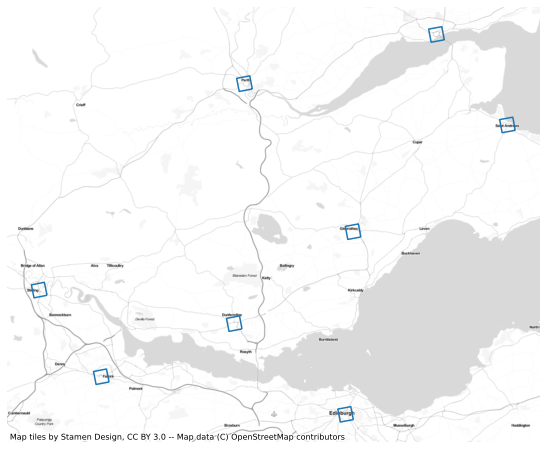

In [9]:
ax = towns_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10, 8))
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
#'http://tile.stamen.com/toner-hybrid/tileZ/tileX/tileY.png'
ax.set_axis_off()

# 2) Rasterio and yt loading comparison
Comparison of the performance of window reads when applied directly in via the functionality available yt_Geotiff.

Define filepath of ESM

In [10]:
data_dir = Path(__name__).absolute().parent.parent 
filepath = data_dir / "sample_data" / "200km_2p5m_N38E34.tif"
background_memory = psutil.virtual_memory().percent

### Performance from loading the full dataset
Attempt to read entire image without performing a window read

In [11]:
user_input = input("Attempt to load entire dataset: Yes(1) No(2): ")

if user_input==1:
    
    full_t1 = time.time()

    with rasterio.open(filepath) as esm_raster:
        esm_data = esm_raster.read()
        esm_data = esm_data.squeeze()
        crs = esm_raster.crs
        transform = esm_raster.transform

    full_t2 = time.time()

    # Calculate load time
    print('Time elapsed= {} seconds'.format(round(full_t2-full_t1,3)))

    # Calculate memory usage 
    background_memory = psutil.virtual_memory().percent
    memory_usage = (psutil.virtual_memory()).percent-background_memory
    print("Total memory usage (%)= {}".format(round(memory_usage,2)))

    

Attempt to load entire dataset: Yes(1) No(2): 2


### Perform a standard Rasterio window read (i.e. read only a portion of the image)
Apply a window read in Rasterio (i.e. read only a subset of the image)

In [12]:
def extract_raster(filepath,city_num):
    with rasterio.open(filepath) as src:
        # Necessary to specify the bounds of the area of interest (i.e. minimum and x,y coordinates)
        rst = src.read(1, window=from_bounds(towns_gdf.bounds.minx[city_num], towns_gdf.bounds.miny[city_num], 
                                             towns_gdf.bounds.maxx[city_num],towns_gdf.bounds.maxy[city_num],src.transform))
        return(rst)  

rasterio_t1 = time.time()

rasterio_city_arrays = {'Edinburgh':extract_raster(filepath,0), 
                        'Stirling':extract_raster(filepath,1), 
                        'Perth':extract_raster(filepath,2), 
                        'Dundee':extract_raster(filepath,3), 
                        'St-Andrews':extract_raster(filepath,4), 
                        'Glenrothes':extract_raster(filepath,5),
                        'Dunfermline':extract_raster(filepath,6), 
                        'Falkirk':extract_raster(filepath,7)}

rasterio_t2 = time.time() 

# Calculate total reading time
rasterio_time = str((round(rasterio_t2-rasterio_t1,3)))

# Calculate difference in RAM usage
rasterio_usage = (psutil.virtual_memory().percent)-background_memory

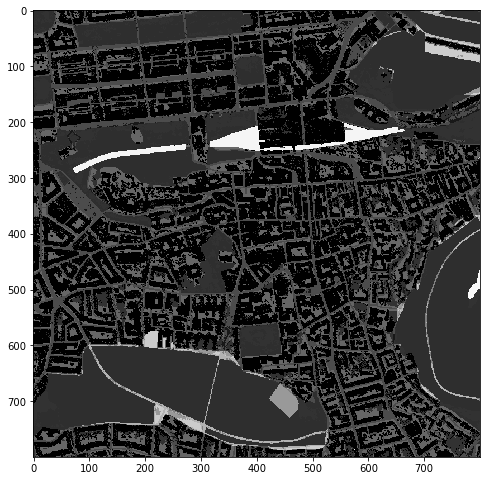

In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 10))
ax1.imshow(rasterio_city_arrays['Edinburgh'], 'gist_yarg', interpolation='none')

### Perform a window read in yt geotiff
Apply a window read via the yt_Geotiff frontend

In [14]:
ds = yt.load(filepath)

yt : [INFO     ] 2021-02-17 09:31:23,217 Parameters: domain_dimensions         = [80000 80000     1]
yt : [INFO     ] 2021-02-17 09:31:23,222 Parameters: domain_left_edge          = [3444000. 3642000.       0.] m
yt : [INFO     ] 2021-02-17 09:31:23,224 Parameters: domain_right_edge         = [3.644e+06 3.842e+06 1.000e+00] m


Extract city polygon centroid coordinates as x, y lists

In [15]:
def getXY_pixel(city_centroids):
    '''Extract centroids from city polygons'''       
    return (city_centroids.x, city_centroids.y)

centroidseries = towns_gdf['geometry'].centroid

center = [list(t) for t in zip(*map(getXY_pixel, centroidseries))]
point_center = np.array(center)

In [16]:
point_center

array([[3501736.29518092, 3459911.11783172, 3496231.15650557,
        3525843.02883963, 3533800.50145809, 3508024.70351689,
        3487798.38038171, 3466522.22072831],
       [3724772.1210987 , 3751950.19419569, 3776563.15539271,
        3778530.99371043, 3763294.9268707 , 3751698.47289724,
        3741375.99752138, 3737289.58826949]])

Extract raster based on rectangular object define from center coordinates (x,y), width and height

In [17]:
# Define a Apoint_center[0:2,0]-width)OI radius
width = ds.arr(2000., 'm')
height = ds.arr(2000.,'m') 

yt_t1 = time.time()

yt_city_arrays = {'Edinburgh':ds.rectangle_from_center((ds.arr(point_center[0:2,0],'m')),width,height)[('bands','1')], 
                  'Stirling':ds.rectangle_from_center((ds.arr(point_center[0:2,1],'m')),width,height)[('bands','1')], 
                  'Perth':ds.rectangle_from_center((ds.arr(point_center[0:2,2],'m')),width,height)[('bands','1')], 
                  'Dundee':ds.rectangle_from_center((ds.arr(point_center[0:2,3],'m')),width,height)[('bands','1')], 
                  'St-Andrews':ds.rectangle_from_center((ds.arr(point_center[0:2,4],'m')),width,height)[('bands','1')], 
                  'Glenrothes':ds.rectangle_from_center((ds.arr(point_center[0:2,5],'m')),width,height)[('bands','1')],
                  'Dunfermline':ds.rectangle_from_center((ds.arr(point_center[0:2,6],'m')),width,height)[('bands','1')], 
                  'Falkirk':ds.rectangle_from_center((ds.arr(point_center[0:2,7],'m')),width,height)[('bands','1')]}

yt_t2 = time.time()

yt_memory_usage = ((psutil.virtual_memory().percent)-background_memory)-rasterio_usage

Load performance comparison

In [18]:
data = {'Test'      : ["Loading time (sec.)", "CPU usage"],
        'Rasterio'  : [round(rasterio_t2-rasterio_t1,3), rasterio_usage],
        'yt'        : [round(yt_t2-yt_t1,3),yt_memory_usage]}
df = pd.DataFrame(data)
df

,Test,Rasterio,yt
0,Loading time (sec.),0.53,0.614
1,CPU usage,0.70,0.300


yt : [INFO     ] 2021-02-17 09:31:24,872 Parameters: domain_dimensions         = [80000 80000     1]
yt : [INFO     ] 2021-02-17 09:31:24,874 Parameters: domain_left_edge          = [3444000. 3642000.       0.] m
yt : [INFO     ] 2021-02-17 09:31:24,876 Parameters: domain_right_edge         = [3.644e+06 3.842e+06 1.000e+00] m
yt : [INFO     ] 2021-02-17 09:31:26,230 xlim = 3500736.295181 3502736.295181
yt : [INFO     ] 2021-02-17 09:31:26,232 ylim = 3723772.121099 3725772.121099
yt : [INFO     ] 2021-02-17 09:31:26,236 xlim = 3500736.295181 3502736.295181
yt : [INFO     ] 2021-02-17 09:31:26,238 ylim = 3723772.121099 3725772.121099
yt : [INFO     ] 2021-02-17 09:31:26,241 Making a fixed resolution buffer of (('bands', '1')) 800 by 800



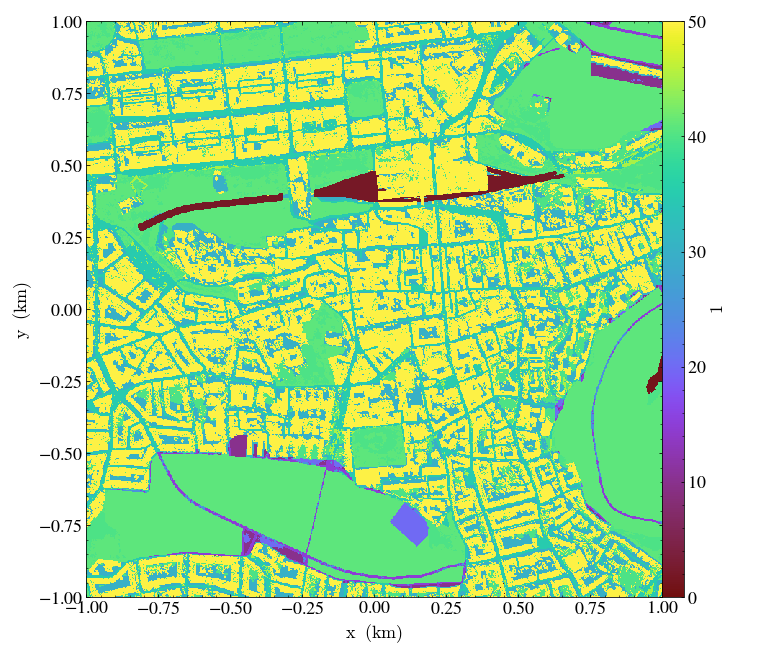

In [19]:
ds = yt.load(filepath)
p = ds.plot(('bands', '1'), height=(2., 'km'), width=(2., 'km'), center=(ds.arr(point_center[0:2,0],'m')))
p.set_log(('bands', '1'), False)
p.show()

# 3) Further developments & Next steps

### Additional data containers

Different data container shapes (e.g. circle) can be supported in yt_Geotiff. Interested in additional shapes?

yt : [INFO     ] 2021-02-17 10:06:10,828 xlim = 3500736.295181 3502736.295181
yt : [INFO     ] 2021-02-17 10:06:10,829 ylim = 3723772.121099 3725772.121099
yt : [INFO     ] 2021-02-17 10:06:10,830 xlim = 3500736.295181 3502736.295181
yt : [INFO     ] 2021-02-17 10:06:10,831 ylim = 3723772.121099 3725772.121099
yt : [INFO     ] 2021-02-17 10:06:10,833 Making a fixed resolution buffer of (('bands', '1')) 800 by 800



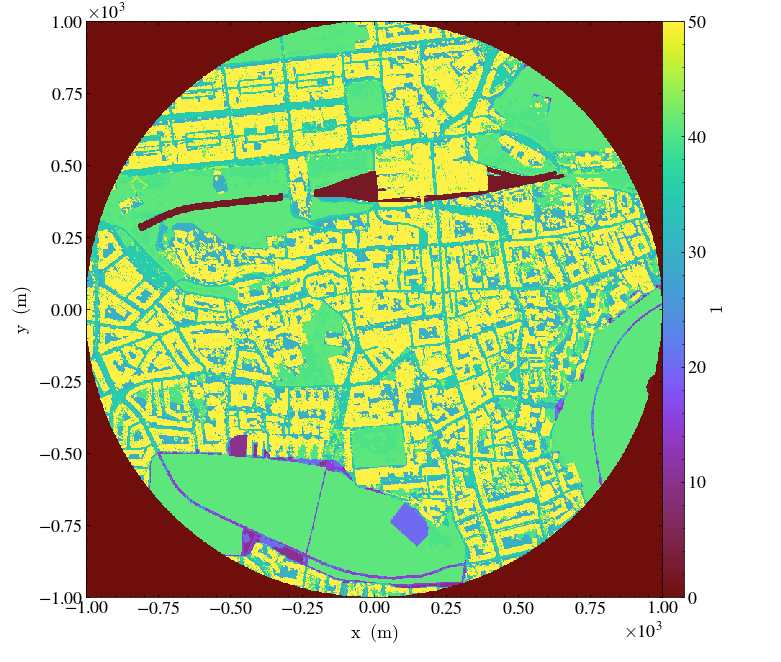

In [23]:
radius = ds.arr(1000.,'m')
circle_centre = ds.arr(point_center[0:2,0],'m')

cp = ds.circle(circle_centre, radius)
               
q = ds.plot([('bands','1')],cp)
q.set_log(('bands', '1'), False)
q.show()


### Distance to pixel unit conversion

In [21]:
ds = yt.load(filepath)
distance = ds.arr(6., 'km')
distance.to('pixels')

yt : [INFO     ] 2021-02-17 09:31:34,403 Parameters: domain_dimensions         = [80000 80000     1]
yt : [INFO     ] 2021-02-17 09:31:34,405 Parameters: domain_left_edge          = [3444000. 3642000.       0.] m
yt : [INFO     ] 2021-02-17 09:31:34,407 Parameters: domain_right_edge         = [3.644e+06 3.842e+06 1.000e+00] m


unyt_array(2400., 'pixels')

### Milestone 2: yt_Geotiff developments to support multi-resolution data
The second project milestone will principally include developments to yt_Geotiff in order to support the fusion of multispectral acquisitions from multiple satellites/sensors and/or platforms (e.g. UAV) at different spatial resolutions. Within a multi-resolution stack, the coarse-scale datasets will be dissagregated to match the highest resolution datasets. 

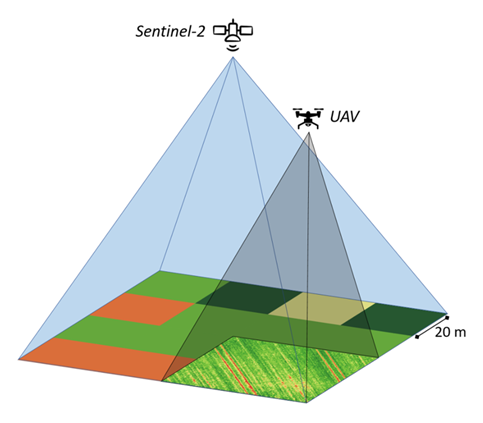
